<a href="https://colab.research.google.com/github/Saoudyahya/Image-Debt-Estimation-Model/blob/main/Debt_Estimation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
==== Depth Estimation Demo ====
Model already exists at models/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
<ipython-input-7-b71f38154bf8>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.m

MiDaS model loaded successfully!

Choose your option:
1. Process example image
2. Process image from URL
3. Upload your own image
4. Capture from webcam
Enter your choice (1-4): 3
Please upload an image:


Saving images.jpeg to images.jpeg
Processing images.jpeg...


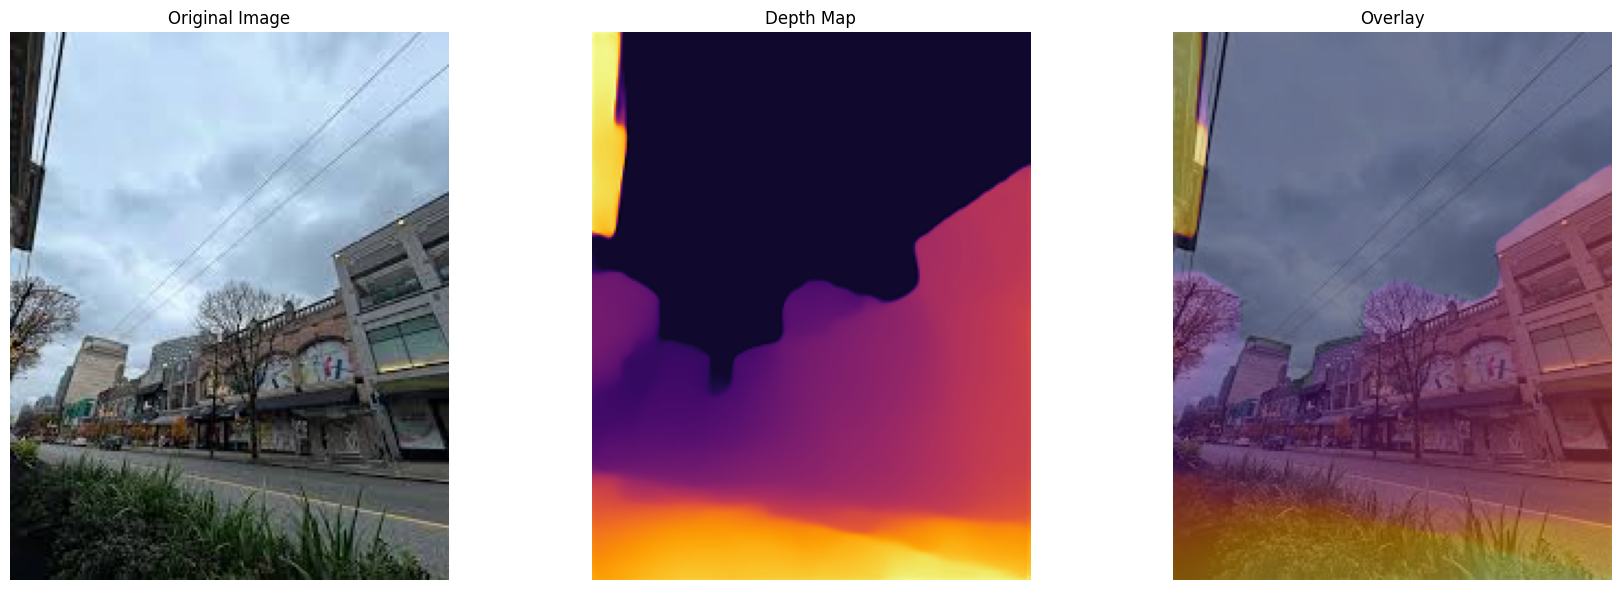


Would you like to see a 3D visualization? (yes/no)
yes


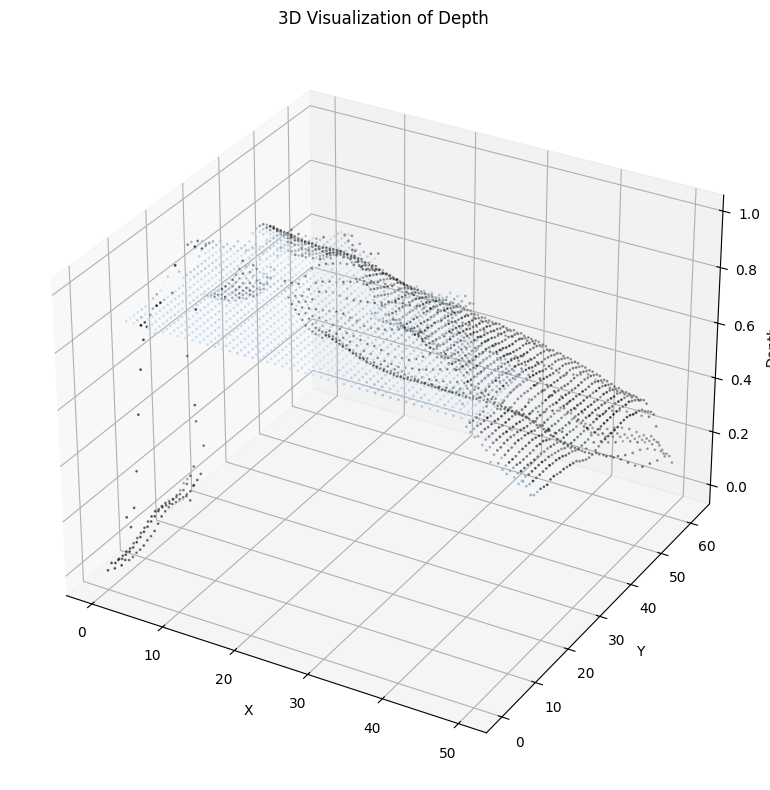


Would you like to save the results? (yes/no)
no

Depth estimation completed successfully!


In [ ]:
# Depth Estimation from Images
# For Google Colab

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import cv2
from PIL import Image
import urllib.request
from google.colab import files
from IPython.display import display, HTML

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
!pip install timm

# Download MiDaS model (if not already downloaded)
def download_model():
    print("Downloading MiDaS model weights...")
    os.makedirs("models", exist_ok=True)

    # Small model variant
    midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
    model_path = "models/midas_v21_small_256.pt"

    if not os.path.exists(model_path):
        urllib.request.urlretrieve(midas_model_url, model_path)
        print(f"Model downloaded to {model_path}")
    else:
        print(f"Model already exists at {model_path}")

    return model_path

# Load MiDaS model
class MidasNet(torch.nn.Module):
    """MiDaS network architecture for depth estimation"""
    def __init__(self, path):
        super(MidasNet, self).__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        if path:
            self.model.load_state_dict(torch.load(path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

# Image preprocessing transformation
def transform_image(img):
    """Transform image for input to MiDaS"""
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    return img

# Estimate depth from image
def estimate_depth(img_path, model):
    """Estimate depth from an image file"""
    # Load image
    if isinstance(img_path, str):
        img = Image.open(img_path).convert("RGB")
    else:
        img = Image.fromarray(img_path).convert("RGB")

    # Original image dimensions for later resizing
    width, height = img.size

    # Transform image for model input
    transformed_img = transform_image(img)

    # Predict depth
    with torch.no_grad():
        prediction = model(transformed_img)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255.0
    depth_map = depth_map.astype(np.uint8)

    return depth_map, np.array(img)

# Visualization function
def visualize_depth(rgb_img, depth_map, colormap=cv2.COLORMAP_INFERNO, alpha=0.5):
    """Visualize depth map"""
    # Apply colormap to depth
    depth_colored = cv2.applyColorMap(depth_map, colormap)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    # Resize RGB image if sizes don't match
    if rgb_img.shape[:2] != depth_colored.shape[:2]:
        rgb_img = cv2.resize(rgb_img, (depth_colored.shape[1], depth_colored.shape[0]))

    # Create overlay
    overlay = cv2.addWeighted(rgb_img, 1-alpha, depth_colored, alpha, 0)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_colored)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return depth_colored, overlay

# Function to process image from URL
def process_from_url(url, model, colormap=cv2.COLORMAP_INFERNO):
    """Process image from URL"""
    # Download image
    print(f"Downloading image from {url}")
    urllib.request.urlretrieve(url, "temp_image.jpg")

    # Estimate depth
    depth_map, rgb_img = estimate_depth("temp_image.jpg", model)

    # Visualize
    depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    # Clean up
    if os.path.exists("temp_image.jpg"):
        os.remove("temp_image.jpg")

    return rgb_img, depth_map, depth_colored, overlay

# Function to process uploaded image
def process_uploaded_image(model, colormap=cv2.COLORMAP_INFERNO):
    """Process uploaded image"""
    print("Please upload an image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        depth_map, rgb_img = estimate_depth(filename, model)
        depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    return rgb_img, depth_map, depth_colored, overlay

# Function to process image from webcam
def process_from_webcam(model, colormap=cv2.COLORMAP_INFERNO):
    """Capture and process image from webcam"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])

    # Convert binary to numpy array
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Estimate depth
    depth_map, _ = estimate_depth(img, model)

    # Visualize
    depth_colored, overlay = visualize_depth(img, depth_map, colormap)

    return img, depth_map, depth_colored, overlay

# Function to perform 3D visualization from depth map
def visualize_3d(rgb_img, depth_map, downsample=4):
    """Create 3D visualization from depth map"""
    try:
        from mpl_toolkits.mplot3d import Axes3D
    except:
        print("3D plotting requires mpl_toolkits.mplot3d")
        return

    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create surface plot
    z = depth_downsampled / 255.0  # Normalize to 0-1
    # Flip z to make closer objects higher
    z = 1 - z

    # Flatten for scatter
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3) / 255.0

    # Plot
    ax.scatter(x_flat, y_flat, z_flat, c=colors, s=1)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Depth')
    ax.set_title('3D Visualization of Depth')

    plt.tight_layout()
    plt.show()

# Save results function
def save_results(rgb_img, depth_map, depth_colored, overlay):
    """Save all results to files"""
    cv2.imwrite("original.jpg", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite("depth_map.jpg", depth_map)
    cv2.imwrite("depth_colored.jpg", cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR))
    cv2.imwrite("overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print("Results saved to:")
    print("  - original.jpg")
    print("  - depth_map.jpg")
    print("  - depth_colored.jpg")
    print("  - overlay.jpg")

    # Download files
    for file in ["original.jpg", "depth_map.jpg", "depth_colored.jpg", "overlay.jpg"]:
        files.download(file)

# Main function to run the demo
def run_depth_estimation_demo():
    """Run full depth estimation demo"""
    print("==== Depth Estimation Demo ====")

    # Download model
    model_path = download_model()

    # Setup MiDaS model
    try:
        model = MidasNet(model_path)
        print("MiDaS model loaded successfully!")
    except Exception as e:
        print(f"Error loading MiDaS model: {e}")
        print("Trying to load model directly from torch hub...")
        try:
            model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
            model.eval()
            print("Successfully loaded MiDaS model from torch hub!")
        except Exception as e:
            print(f"Failed to load model: {e}")
            return

    print("\nChoose your option:")
    print("1. Process example image")
    print("2. Process image from URL")
    print("3. Upload your own image")
    print("4. Capture from webcam")

    choice = input("Enter your choice (1-4): ")

    if choice == "1":
        # Process example image
        example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
        rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)

    elif choice == "2":
        # Process from URL
        url = input("Enter image URL: ")
        rgb_img, depth_map, depth_colored, overlay = process_from_url(url, model)

    elif choice == "3":
        # Process uploaded image
        rgb_img, depth_map, depth_colored, overlay = process_uploaded_image(model)

    elif choice == "4":
        # Process from webcam
        rgb_img, depth_map, depth_colored, overlay = process_from_webcam(model)

    else:
        print("Invalid choice! Using example image.")
        example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
        rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)

    # Additional visualizations
    print("\nWould you like to see a 3D visualization? (yes/no)")
    viz_3d = input().lower().startswith('y')

    if viz_3d:
        visualize_3d(rgb_img, depth_map)

    # Save results
    print("\nWould you like to save the results? (yes/no)")
    save = input().lower().startswith('y')

    if save:
        save_results(rgb_img, depth_map, depth_colored, overlay)

    print("\nDepth estimation completed successfully!")
    return rgb_img, depth_map, depth_colored, overlay

# Run the demo
if __name__ == "__main__":
    run_depth_estimation_demo()

Using device: cpu
==== Enhanced Depth Estimation Demo with Map Integration ====
Model already exists at models/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


<ipython-input-9-fa30196d7495>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path, map_location=device))


MiDaS model loaded successfully!

Choose your option:
1. Process example image
2. Process image from URL
3. Upload your own image
4. Capture from webcam
5. View current map
6. Exit
Enter your choice (1-6): 3
Please upload an image:


Saving images.jpeg to images (3).jpeg
Processing images (3).jpeg...


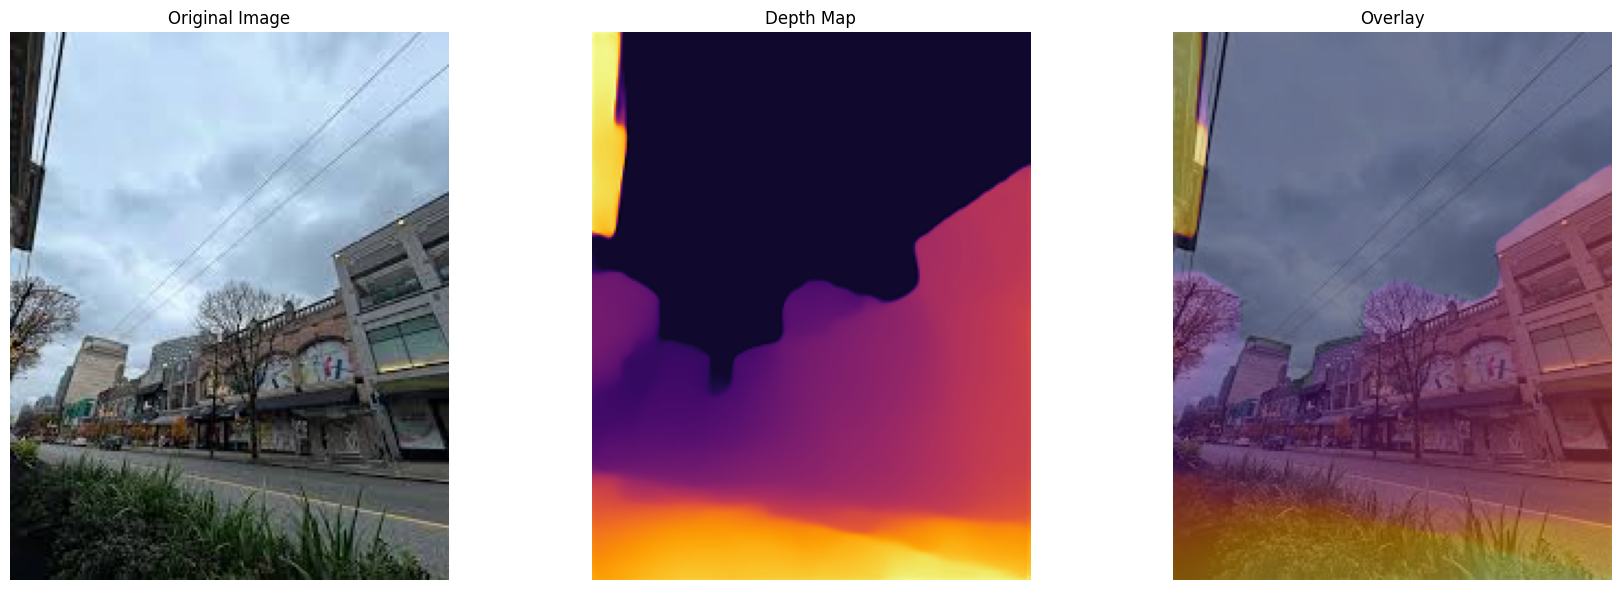


Generating 3D visualization...


<ipython-input-9-fa30196d7495>:277: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


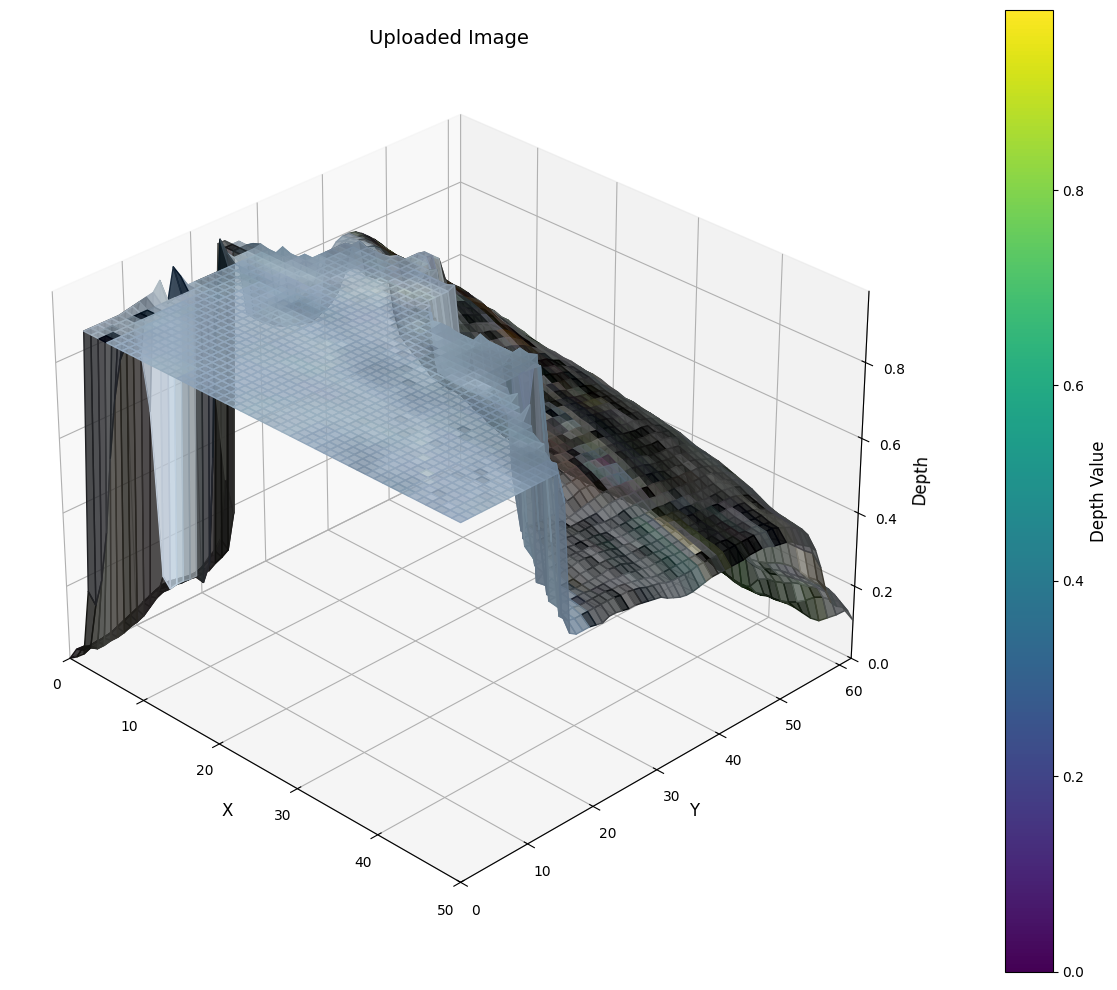

KeyboardInterrupt: Interrupted by user

In [ ]:
# Enhanced Depth Estimation from Images with 3D Map Integration
# For Google Colab

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import cv2
from PIL import Image
import urllib.request
from google.colab import files
from IPython.display import display, HTML
import io
import base64
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium import plugins
import json

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
!pip install timm
!pip install folium

# Global variable to store the depth map collection
depth_collection = []

# Download MiDaS model (if not already downloaded)
def download_model():
    print("Downloading MiDaS model weights...")
    os.makedirs("models", exist_ok=True)

    # Small model variant
    midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
    model_path = "models/midas_v21_small_256.pt"

    if not os.path.exists(model_path):
        urllib.request.urlretrieve(midas_model_url, model_path)
        print(f"Model downloaded to {model_path}")
    else:
        print(f"Model already exists at {model_path}")

    return model_path

# Load MiDaS model
class MidasNet(torch.nn.Module):
    """MiDaS network architecture for depth estimation"""
    def __init__(self, path):
        super(MidasNet, self).__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        if path:
            self.model.load_state_dict(torch.load(path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

# Image preprocessing transformation
def transform_image(img):
    """Transform image for input to MiDaS"""
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    return img

# Estimate depth from image
def estimate_depth(img_path, model):
    """Estimate depth from an image file"""
    # Load image
    if isinstance(img_path, str):
        img = Image.open(img_path).convert("RGB")
    else:
        img = Image.fromarray(img_path).convert("RGB")

    # Original image dimensions for later resizing
    width, height = img.size

    # Transform image for model input
    transformed_img = transform_image(img)

    # Predict depth
    with torch.no_grad():
        prediction = model(transformed_img)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255.0
    depth_map = depth_map.astype(np.uint8)

    return depth_map, np.array(img)

# Visualization function
def visualize_depth(rgb_img, depth_map, colormap=cv2.COLORMAP_INFERNO, alpha=0.5):
    """Visualize depth map"""
    # Apply colormap to depth
    depth_colored = cv2.applyColorMap(depth_map, colormap)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    # Resize RGB image if sizes don't match
    if rgb_img.shape[:2] != depth_colored.shape[:2]:
        rgb_img = cv2.resize(rgb_img, (depth_colored.shape[1], depth_colored.shape[0]))

    # Create overlay
    overlay = cv2.addWeighted(rgb_img, 1-alpha, depth_colored, alpha, 0)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_colored)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return depth_colored, overlay

# Function to process image from URL
def process_from_url(url, model, colormap=cv2.COLORMAP_INFERNO):
    """Process image from URL"""
    # Download image
    print(f"Downloading image from {url}")
    urllib.request.urlretrieve(url, "temp_image.jpg")

    # Estimate depth
    depth_map, rgb_img = estimate_depth("temp_image.jpg", model)

    # Visualize
    depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    # Clean up
    if os.path.exists("temp_image.jpg"):
        os.remove("temp_image.jpg")

    return rgb_img, depth_map, depth_colored, overlay

# Function to process uploaded image
def process_uploaded_image(model, colormap=cv2.COLORMAP_INFERNO):
    """Process uploaded image"""
    print("Please upload an image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        depth_map, rgb_img = estimate_depth(filename, model)
        depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    return rgb_img, depth_map, depth_colored, overlay

# Function to process image from webcam
def process_from_webcam(model, colormap=cv2.COLORMAP_INFERNO):
    """Capture and process image from webcam"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])

    # Convert binary to numpy array
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Estimate depth
    depth_map, _ = estimate_depth(img, model)

    # Visualize
    depth_colored, overlay = visualize_depth(img, depth_map, colormap)

    return img, depth_map, depth_colored, overlay

# Improved 3D visualization from depth map
def visualize_3d(rgb_img, depth_map, title="3D Visualization of Depth", downsample=4, save_fig=False):
    """Create improved 3D visualization from depth map"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create surface plot
    z = depth_downsampled / 255.0  # Normalize to 0-1
    # Flip z to make closer objects higher
    z = 1 - z

    # Flatten for scatter
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3) / 255.0

    # Add a mesh grid
    ax.plot_surface(x, y, z, facecolors=rgb_downsampled/255.0,
                    rstride=1, cstride=1, alpha=0.8, antialiased=True)

    # Set labels and view angle
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Depth', fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set camera angle
    ax.view_init(elev=30, azim=-45)

    # Add colorbar to show depth
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(z.min(), z.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label('Depth Value', fontsize=12)

    # Add a grid
    ax.grid(True)

    # Set axis limits
    ax.set_xlim(0, x.max())
    ax.set_ylim(0, y.max())
    ax.set_zlim(z.min(), z.max())

    plt.tight_layout()

    if save_fig:
        plt.savefig('3d_visualization.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Save the data for map integration
    return {
        'x': x_flat.tolist(),
        'y': y_flat.tolist(),
        'z': z_flat.tolist(),
        'colors': colors.tolist(),
        'title': title
    }

# Function to create a 3D point cloud that can be exported
def create_point_cloud(depth_map, rgb_img, downsample=8):
    """Create a point cloud from depth map and RGB image"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Normalize depth
    z = depth_downsampled / 255.0  # Normalize to 0-1
    z = 1 - z  # Flip so closer objects are higher

    # Flatten for point cloud
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3).tolist()

    # Create point cloud data
    points = []
    for i in range(len(x_flat)):
        points.append({
            'x': float(x_flat[i]),
            'y': float(y_flat[i]),
            'z': float(z_flat[i]),
            'r': colors[i][0],
            'g': colors[i][1],
            'b': colors[i][2]
        })

    return points

# Function to initialize or update the map with 3D visualizations
def update_map_with_3d(depth_collection, map_center=[0, 0], zoom_start=2):
    """Create or update a map with 3D visualizations from the depth collection"""
    # Create a map
    m = folium.Map(location=map_center, zoom_start=zoom_start, control_scale=True)

    # Add each 3D visualization to the map
    for i, item in enumerate(depth_collection):
        if 'geo_location' in item:
            # Add a marker for this 3D visualization
            popup_html = f"""
            <div style="width:300px">
                <h3>{item['title']}</h3>
                <img src="data:image/jpeg;base64,{item['thumbnail']}" style="width:100%">
                <p>Depth visualization #{i+1}</p>
                <button onclick="window.open('3d_visualization_{i}.html', '_blank')">View 3D Model</button>
            </div>
            """

            folium.Marker(
                location=item['geo_location'],
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=item['title'],
                icon=folium.Icon(icon='camera', prefix='fa')
            ).add_to(m)

    # Save the map to an HTML file
    map_filename = 'depth_map.html'
    m.save(map_filename)

    # Display the map
    display(HTML(f'<iframe src="{map_filename}" width="100%" height="500px"></iframe>'))

    return m

# Function to add a new 3D visualization to the collection with geo-location
def add_to_map(rgb_img, depth_map, depth_colored, title, location, downsample=8):
    """Add a 3D visualization to the map collection"""
    global depth_collection

    # Create point cloud data
    point_cloud = create_point_cloud(depth_map, rgb_img, downsample)

    # Create a thumbnail for the popup
    plt.figure(figsize=(4, 3))
    plt.imshow(depth_colored)
    plt.axis('off')
    plt.tight_layout(pad=0)

    # Save thumbnail as base64
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', bbox_inches='tight', pad_inches=0)
    plt.close()
    buf.seek(0)
    thumbnail = base64.b64encode(buf.read()).decode('utf-8')

    # Create the entry for the collection
    entry = {
        'title': title,
        'geo_location': location,
        'thumbnail': thumbnail,
        'point_cloud': point_cloud,
        'original_shape': depth_map.shape
    }

    # Add to collection
    depth_collection.append(entry)

    # Generate individual 3D HTML for this entry
    generate_3d_html(len(depth_collection) - 1)

    # Update the map
    update_map_with_3d(depth_collection)

    print(f"Added visualization '{title}' at location {location} to the map.")
    return len(depth_collection) - 1  # Return index of the added entry

# Function to generate an HTML file with a 3D visualization using Three.js
def generate_3d_html(index):
    """Generate an HTML file with a 3D visualization of a point cloud using Three.js"""
    if index >= len(depth_collection):
        print(f"Error: Index {index} out of range")
        return

    item = depth_collection[index]
    point_cloud = item['point_cloud']

    # Create a simplified point cloud for the web
    # Sample points to reduce size if needed
    max_points = 10000
    if len(point_cloud) > max_points:
        step = len(point_cloud) // max_points
        point_cloud = point_cloud[::step]

    # Convert point cloud to a format for Three.js
    points_data = []
    colors_data = []
    for point in point_cloud:
        points_data.append([point['x'], point['y'], point['z']])
        colors_data.append([point['r']/255, point['g']/255, point['b']/255])

    # Create HTML content
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>{item['title']} - 3D Visualization</title>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/dat-gui/0.7.7/dat.gui.min.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/stats.js/r17/Stats.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/controls/OrbitControls.min.js"></script>
        <style>
            body {{ margin: 0; overflow: hidden; }}
            canvas {{ width: 100%; height: 100%; display: block; }}
            #info {{
                position: absolute;
                top: 10px;
                width: 100%;
                text-align: center;
                color: white;
                font-family: Arial, sans-serif;
                font-size: 14px;
                z-index: 100;
                pointer-events: none;
            }}
        </style>
    </head>
    <body>
        <div id="info">{item['title']} - Use mouse to rotate, scroll to zoom</div>
        <script>
            // Scene setup
            const scene = new THREE.Scene();
            scene.background = new THREE.Color(0x111111);

            // Camera setup
            const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
            camera.position.set(0, -50, 50);
            camera.up.set(0, 0, 1); // Set z-up

            // Renderer setup
            const renderer = new THREE.WebGLRenderer({{ antialias: true }});
            renderer.setSize(window.innerWidth, window.innerHeight);
            document.body.appendChild(renderer.domElement);

            // Controls
            const controls = new THREE.OrbitControls(camera, renderer.domElement);
            controls.enableDamping = true;
            controls.dampingFactor = 0.25;

            // Light
            const ambientLight = new THREE.AmbientLight(0xffffff, 0.5);
            scene.add(ambientLight);

            const directionalLight = new THREE.DirectionalLight(0xffffff, 0.8);
            directionalLight.position.set(1, 1, 1);
            scene.add(directionalLight);

            // Helper functions
            function normalizePoints(points) {{
                // Find bounds
                let minX = Infinity, minY = Infinity, minZ = Infinity;
                let maxX = -Infinity, maxY = -Infinity, maxZ = -Infinity;

                points.forEach(p => {{
                    minX = Math.min(minX, p[0]);
                    minY = Math.min(minY, p[1]);
                    minZ = Math.min(minZ, p[2]);
                    maxX = Math.max(maxX, p[0]);
                    maxY = Math.max(maxY, p[1]);
                    maxZ = Math.max(maxZ, p[2]);
                }});

                // Center and scale
                const centerX = (minX + maxX) / 2;
                const centerY = (minY + maxY) / 2;
                const centerZ = (minZ + maxZ) / 2;

                const scale = 100 / Math.max(maxX - minX, maxY - minY, maxZ - minZ);

                return points.map(p => [
                    (p[0] - centerX) * scale,
                    (p[1] - centerY) * scale,
                    (p[2] - centerZ) * scale
                ]);
            }}

            // Point cloud data
            const pointsData = {json.dumps(points_data)};
            const colorsData = {json.dumps(colors_data)};

            // Normalize point positions for better display
            const normalizedPoints = normalizePoints(pointsData);

            // Create point cloud
            const geometry = new THREE.BufferGeometry();
            const positions = [];
            const colors = [];

            for (let i = 0; i < normalizedPoints.length; i++) {{
                positions.push(normalizedPoints[i][0], normalizedPoints[i][1], normalizedPoints[i][2]);
                colors.push(colorsData[i][0], colorsData[i][1], colorsData[i][2]);
            }}

            geometry.setAttribute('position', new THREE.Float32BufferAttribute(positions, 3));
            geometry.setAttribute('color', new THREE.Float32BufferAttribute(colors, 3));

            const material = new THREE.PointsMaterial({{
                size: 0.5,
                vertexColors: true,
                sizeAttenuation: true
            }});

            const pointCloud = new THREE.Points(geometry, material);
            scene.add(pointCloud);

            // Add axes helper
            const axesHelper = new THREE.AxesHelper(5);
            scene.add(axesHelper);

            // Add grid
            const gridHelper = new THREE.GridHelper(100, 10);
            gridHelper.rotation.x = Math.PI / 2;
            scene.add(gridHelper);

            // GUI controls
            const gui = new dat.GUI();
            const params = {{
                pointSize: 0.5,
                showAxes: true,
                showGrid: true,
                rotateModel: false
            }};

            gui.add(params, 'pointSize', 0.1, 3).onChange(value => {{
                material.size = value;
            }});

            gui.add(params, 'showAxes').onChange(value => {{
                axesHelper.visible = value;
            }});

            gui.add(params, 'showGrid').onChange(value => {{
                gridHelper.visible = value;
            }});

            gui.add(params, 'rotateModel');

            // Handle window resize
            window.addEventListener('resize', () => {{
                camera.aspect = window.innerWidth / window.innerHeight;
                camera.updateProjectionMatrix();
                renderer.setSize(window.innerWidth, window.innerHeight);
            }});

            // Animation loop
            function animate() {{
                requestAnimationFrame(animate);

                if (params.rotateModel) {{
                    pointCloud.rotation.z += 0.005;
                }}

                controls.update();
                renderer.render(scene, camera);
            }}

            animate();
        </script>
    </body>
    </html>
    """

    # Write to file
    filename = f'3d_visualization_{index}.html'
    with open(filename, 'w') as f:
        f.write(html_content)

    print(f"Generated 3D visualization HTML at {filename}")
    return filename

# Save results function
def save_results(rgb_img, depth_map, depth_colored, overlay):
    """Save all results to files"""
    cv2.imwrite("original.jpg", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite("depth_map.jpg", depth_map)
    cv2.imwrite("depth_colored.jpg", cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR))
    cv2.imwrite("overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print("Results saved to:")
    print("  - original.jpg")
    print("  - depth_map.jpg")
    print("  - depth_colored.jpg")
    print("  - overlay.jpg")

    # Download files
    for file in ["original.jpg", "depth_map.jpg", "depth_colored.jpg", "overlay.jpg"]:
        files.download(file)

# Main function to run the demo
def run_depth_estimation_demo():
    """Run full depth estimation demo with map integration"""
    print("==== Enhanced Depth Estimation Demo with Map Integration ====")

    # Download model
    model_path = download_model()

    # Setup MiDaS model
    try:
        model = MidasNet(model_path)
        print("MiDaS model loaded successfully!")
    except Exception as e:
        print(f"Error loading MiDaS model: {e}")
        print("Trying to load model directly from torch hub...")
        try:
            model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
            model.eval()
            print("Successfully loaded MiDaS model from torch hub!")
        except Exception as e:
            print(f"Failed to load model: {e}")
            return

    while True:
        print("\nChoose your option:")
        print("1. Process example image")
        print("2. Process image from URL")
        print("3. Upload your own image")
        print("4. Capture from webcam")
        print("5. View current map")
        print("6. Exit")

        choice = input("Enter your choice (1-6): ")

        if choice == "6":
            break

        if choice == "5":
            if not depth_collection:
                print("No data added to map yet.")
            else:
                update_map_with_3d(depth_collection)
            continue

        if choice in ["1", "2", "3", "4"]:
            if choice == "1":
                # Process example image
                example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
                rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)
                title = "Example Image"

            elif choice == "2":
                # Process from URL
                url = input("Enter image URL: ")
                rgb_img, depth_map, depth_colored, overlay = process_from_url(url, model)
                title = "URL Image"

            elif choice == "3":
                # Process uploaded image
                rgb_img, depth_map, depth_colored, overlay = process_uploaded_image(model)
                title = "Uploaded Image"

            elif choice == "4":
                # Process from webcam
                rgb_img, depth_map, depth_colored, overlay = process_from_webcam(model)
                title = "Webcam Capture"

            # Enhanced 3D visualization
            print("\nGenerating 3D visualization...")
            visualize_3d(rgb_img, depth_map, title=title)

            # Ask if user wants to add to map
            add_to_map_choice = input("\nWould you like to add this visualization to the map? (yes/no): ")

            if add_to_map_choice.lower().startswith('y'):
                print("Enter location coordinates for the map:")
                try:
                    lat = float(input("Latitude (e.g., 37.7749): "))
                    lng = float(input("Longitude (e.g., -122.4194): "))
                    location_name = input("Enter a name for this location: ")

                    # Add to map
                    index = add_to_map(rgb_img, depth_map, depth_colored,
                                      f"{title} - {location_name}", [lat, lng])

                    print(f"Added to map at index {index}")
                except ValueError:
                    print("Invalid coordinates. Using default location.")
                    index = add_to_map(rgb_img, depth_map, depth_colored,
                                      title, [0, 0])

            # Save results
            save_choice = input("\nWould you like to save the results? (yes/no): ")
            if save_choice.lower().startswith('y'):
                save_results(rgb_img, depth_map, depth_colored, overlay)
        else:
            print("Invalid choice!")

    # Final map view
    if depth_collection:
        print("\nGenerating final map with all visualizations...")
        m = update_map_with_3d(depth_collection)
        # Save and download map
        map_filename = 'depth_map.html'
        m.save(map_filename)
        files.download(map_filename)

        # Also download individual 3D visualizations
        for i in range(len(depth_collection)):
            files.download(f'3d_visualization_{i}.html')

    print("\nDepth estimation demo completed!")

# Run the demo
if __name__ == "__main__":
    run_depth_estimation_demo()

Using device: cpu
==== Enhanced Depth Estimation Demo with Map Integration ====
Model already exists at models/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
<ipython-input-2-4b13ce05c7ab>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.m

MiDaS model loaded successfully!

Choose your option:
1. Process example image
2. Process image from URL
3. Upload your own image
4. Capture from webcam
5. View current map
6. Exit
Enter your choice (1-6): 3
Please upload an image:


Saving images.jpeg to images (1).jpeg
Processing images (1).jpeg...


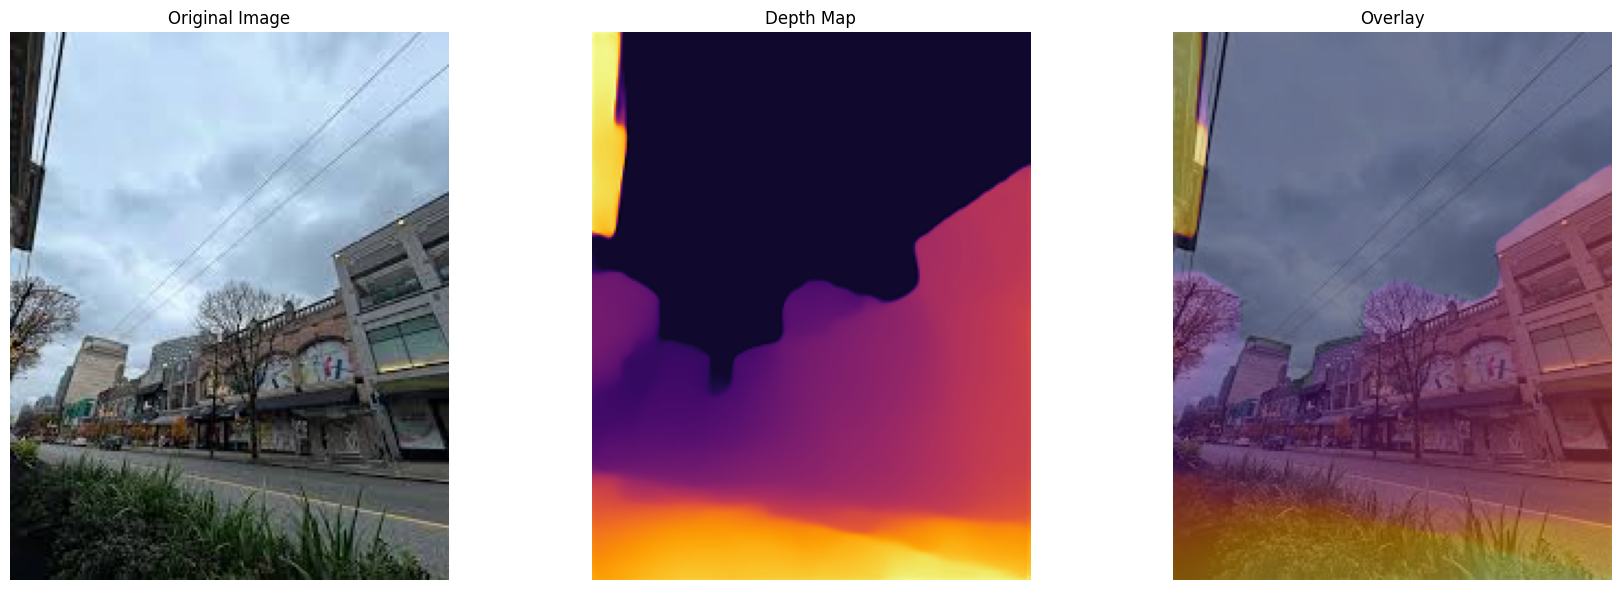


Generating 3D visualization...


<ipython-input-2-4b13ce05c7ab>:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


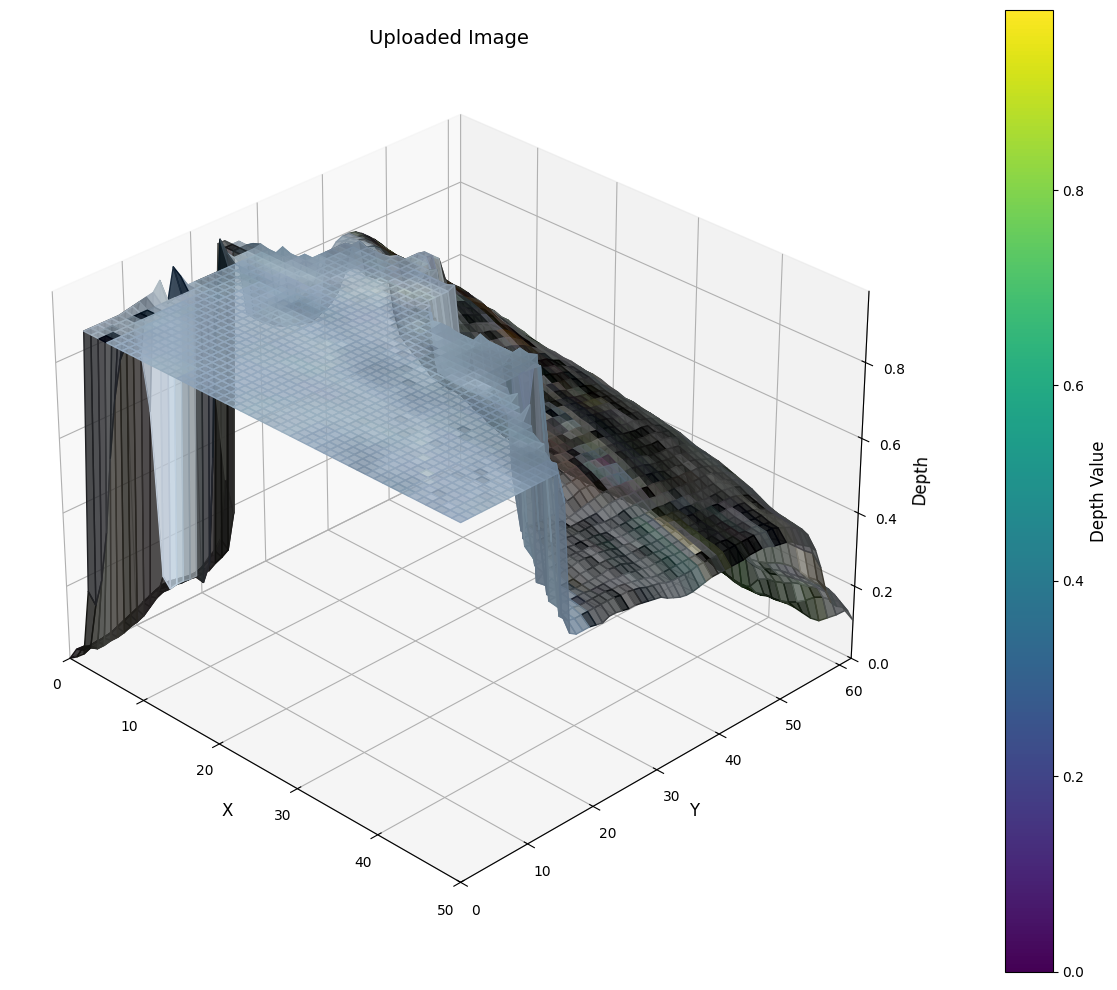


Would you like to add this visualization to the map? (yes/no): yes
Enter location coordinates for the map:
Latitude (e.g., 37.7749): 50
Longitude (e.g., -122.4194): 50
Enter a name for this location: m
Generated 3D visualization HTML at 3d_visualization_0.html
Download it to view: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Map created successfully. Choose one of these options to view it:
1. Download the HTML file and open it locally:


2. View a simplified version in Colab:


3. Direct download:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Added visualization 'Uploaded Image - m' at location [50.0, 50.0] to the map.
Added to map at index 0

Would you like to save the results? (yes/no): yes
Results saved to:
  - original.jpg
  - depth_map.jpg
  - depth_colored.jpg
  - overlay.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Choose your option:
1. Process example image
2. Process image from URL
3. Upload your own image
4. Capture from webcam
5. View current map
6. Exit


KeyboardInterrupt: Interrupted by user

In [2]:
import os
import io
import cv2
import base64
import numpy as np
import urllib.request
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display, HTML, IFrame, Javascript
from google.colab import files

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
!pip install timm
!pip install folium

# Global variable to store the depth map collection
depth_collection = []

# Download MiDaS model (if not already downloaded)
def download_model():
    print("Downloading MiDaS model weights...")
    os.makedirs("models", exist_ok=True)

    # Small model variant
    midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
    model_path = "models/midas_v21_small_256.pt"

    if not os.path.exists(model_path):
        urllib.request.urlretrieve(midas_model_url, model_path)
        print(f"Model downloaded to {model_path}")
    else:
        print(f"Model already exists at {model_path}")

    return model_path

# Load MiDaS model
class MidasNet(torch.nn.Module):
    """MiDaS network architecture for depth estimation"""
    def __init__(self, path):
        super(MidasNet, self).__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        if path:
            self.model.load_state_dict(torch.load(path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

# Image preprocessing transformation
def transform_image(img):
    """Transform image for input to MiDaS"""
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    return img

# Estimate depth from image
def estimate_depth(img_path, model):
    """Estimate depth from an image file"""
    # Load image
    if isinstance(img_path, str):
        img = Image.open(img_path).convert("RGB")
    else:
        img = Image.fromarray(img_path).convert("RGB")

    # Original image dimensions for later resizing
    width, height = img.size

    # Transform image for model input
    transformed_img = transform_image(img)

    # Predict depth
    with torch.no_grad():
        prediction = model(transformed_img)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255.0
    depth_map = depth_map.astype(np.uint8)

    return depth_map, np.array(img)

# Visualization function
def visualize_depth(rgb_img, depth_map, colormap=cv2.COLORMAP_INFERNO, alpha=0.5):
    """Visualize depth map"""
    # Apply colormap to depth
    depth_colored = cv2.applyColorMap(depth_map, colormap)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    # Resize RGB image if sizes don't match
    if rgb_img.shape[:2] != depth_colored.shape[:2]:
        rgb_img = cv2.resize(rgb_img, (depth_colored.shape[1], depth_colored.shape[0]))

    # Create overlay
    overlay = cv2.addWeighted(rgb_img, 1-alpha, depth_colored, alpha, 0)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_colored)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return depth_colored, overlay

# Function to process image from URL
def process_from_url(url, model, colormap=cv2.COLORMAP_INFERNO):
    """Process image from URL"""
    # Download image
    print(f"Downloading image from {url}")
    urllib.request.urlretrieve(url, "temp_image.jpg")

    # Estimate depth
    depth_map, rgb_img = estimate_depth("temp_image.jpg", model)

    # Visualize
    depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    # Clean up
    if os.path.exists("temp_image.jpg"):
        os.remove("temp_image.jpg")

    return rgb_img, depth_map, depth_colored, overlay

# Function to process uploaded image
def process_uploaded_image(model, colormap=cv2.COLORMAP_INFERNO):
    """Process uploaded image"""
    print("Please upload an image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        depth_map, rgb_img = estimate_depth(filename, model)
        depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    return rgb_img, depth_map, depth_colored, overlay

# Function to process image from webcam
def process_from_webcam(model, colormap=cv2.COLORMAP_INFERNO):
    """Capture and process image from webcam"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])

    # Convert binary to numpy array
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Estimate depth
    depth_map, _ = estimate_depth(img, model)

    # Visualize
    depth_colored, overlay = visualize_depth(img, depth_map, colormap)

    return img, depth_map, depth_colored, overlay

# Improved 3D visualization from depth map
def visualize_3d(rgb_img, depth_map, title="3D Visualization of Depth", downsample=4, save_fig=False):
    """Create improved 3D visualization from depth map"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create surface plot
    z = depth_downsampled / 255.0  # Normalize to 0-1
    # Flip z to make closer objects higher
    z = 1 - z

    # Flatten for scatter
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3) / 255.0

    # Add a mesh grid
    ax.plot_surface(x, y, z, facecolors=rgb_downsampled/255.0,
                    rstride=1, cstride=1, alpha=0.8, antialiased=True)

    # Set labels and view angle
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Depth', fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set camera angle
    ax.view_init(elev=30, azim=-45)

    # Add colorbar to show depth
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(z.min(), z.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label('Depth Value', fontsize=12)

    # Add a grid
    ax.grid(True)

    # Set axis limits
    ax.set_xlim(0, x.max())
    ax.set_ylim(0, y.max())
    ax.set_zlim(z.min(), z.max())

    plt.tight_layout()

    if save_fig:
        plt.savefig('3d_visualization.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Save the data for map integration
    return {
        'x': x_flat.tolist(),
        'y': y_flat.tolist(),
        'z': z_flat.tolist(),
        'colors': colors.tolist(),
        'title': title
    }

# Function to create a 3D point cloud that can be exported
def create_point_cloud(depth_map, rgb_img, downsample=8):
    """Create a point cloud from depth map and RGB image"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Normalize depth
    z = depth_downsampled / 255.0  # Normalize to 0-1
    z = 1 - z  # Flip so closer objects are higher

    # Flatten for point cloud
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3).tolist()

    # Create point cloud data
    points = []
    for i in range(len(x_flat)):
        points.append({
            'x': float(x_flat[i]),
            'y': float(y_flat[i]),
            'z': float(z_flat[i]),
            'r': colors[i][0],
            'g': colors[i][1],
            'b': colors[i][2]
        })

    return points

# MODIFIED: Function to initialize or update the map with 3D visualizations
def update_map_with_3d(depth_collection, map_center=[0, 0], zoom_start=2):
    """Create or update a map with 3D visualizations from the depth collection"""
    import folium

    # Create a map
    m = folium.Map(location=map_center, zoom_start=zoom_start, control_scale=True)

    # Add each 3D visualization to the map
    for i, item in enumerate(depth_collection):
        if 'geo_location' in item:
            # Create base64 thumbnail for popup
            thumbnail_html = f'<img src="data:image/jpeg;base64,{item["thumbnail"]}" style="width:100%">'

            # Create popup with button to open 3D viz
            popup_html = f"""
            <div style="width:300px">
                <h3>{item['title']}</h3>
                {thumbnail_html}
                <p>Depth visualization #{i+1}</p>
                <p>To view the 3D model, please download and open the HTML file</p>
            </div>
            """

            folium.Marker(
                location=item['geo_location'],
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=item['title'],
                icon=folium.Icon(icon='camera', prefix='fa')
            ).add_to(m)

    # Save the map to an HTML file
    map_filename = 'depth_map.html'
    m.save(map_filename)

    # Create a simple alternative map using direct HTML
    create_simple_map(depth_collection, map_center, zoom_start)

    # Display download link instead of embedding
    print(f"Map created successfully. Choose one of these options to view it:")
    print("1. Download the HTML file and open it locally:")
    display(HTML(f'<a href="./files/{map_filename}" download="{map_filename}">Download Folium Map</a>'))
    print("2. View a simplified version in Colab:")
    display(IFrame('simple_map.html', width='100%', height=500))

    # Also offer direct download via Colab
    print("3. Direct download:")
    files.download(map_filename)

    return m

# NEW: Function to create a simple map using direct HTML
def create_simple_map(depth_collection, map_center=[0, 0], zoom_start=2):
    """Create a simple map using HTML and JavaScript"""

    # Extract location data
    locations = []
    for i, item in enumerate(depth_collection):
        if 'geo_location' in item:
            locations.append({
                'lat': item['geo_location'][0],
                'lng': item['geo_location'][1],
                'title': item['title'],
                'index': i
            })

    # Create the HTML content
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Depth Map Visualization</title>
        <meta charset="utf-8">
        <style>
            body { margin: 0; padding: 0; }
            #map { height: 500px; width: 100%; }
        </style>
        <link rel="stylesheet" href="https://unpkg.com/leaflet@1.7.1/dist/leaflet.css" />
        <script src="https://unpkg.com/leaflet@1.7.1/dist/leaflet.js"></script>
    </head>
    <body>
        <div id="map"></div>
        <script>
            const map = L.map('map').setView([""" + str(map_center[0]) + """, """ + str(map_center[1]) + """], """ + str(zoom_start) + """);

            L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
                attribution: '&copy; OpenStreetMap contributors'
            }).addTo(map);

            const locations = """ + json.dumps(locations) + """;

            locations.forEach((loc) => {
                L.marker([loc.lat, loc.lng])
                    .addTo(map)
                    .bindPopup(`<b>${loc.title}</b><br>Depth visualization #${loc.index+1}`);
            });
        </script>
    </body>
    </html>
    """

    # Write to file
    filename = 'simple_map.html'
    with open(filename, 'w') as f:
        f.write(html_content)

    return filename

# Function to add a new 3D visualization to the collection with geo-location
def add_to_map(rgb_img, depth_map, depth_colored, title, location, downsample=8):
    """Add a 3D visualization to the map collection"""
    global depth_collection

    # Create point cloud data
    point_cloud = create_point_cloud(depth_map, rgb_img, downsample)

    # Create a thumbnail for the popup
    plt.figure(figsize=(4, 3))
    plt.imshow(depth_colored)
    plt.axis('off')
    plt.tight_layout(pad=0)

    # Save thumbnail as base64
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', bbox_inches='tight', pad_inches=0)
    plt.close()
    buf.seek(0)
    thumbnail = base64.b64encode(buf.read()).decode('utf-8')

    # Create the entry for the collection
    entry = {
        'title': title,
        'geo_location': location,
        'thumbnail': thumbnail,
        'point_cloud': point_cloud,
        'original_shape': depth_map.shape
    }

    # Add to collection
    depth_collection.append(entry)

    # Generate individual 3D HTML for this entry
    generate_3d_html(len(depth_collection) - 1)

    # Update the map
    update_map_with_3d(depth_collection)

    print(f"Added visualization '{title}' at location {location} to the map.")
    return len(depth_collection) - 1  # Return index of the added entry

# MODIFIED: Function to generate an HTML file with a 3D visualization using Three.js
def generate_3d_html(index):
    """Generate an HTML file with a 3D visualization of a point cloud using Three.js"""
    if index >= len(depth_collection):
        print(f"Error: Index {index} out of range")
        return

    item = depth_collection[index]
    point_cloud = item['point_cloud']

    # Create a simplified point cloud for the web
    # Sample points to reduce size if needed
    max_points = 10000
    if len(point_cloud) > max_points:
        step = len(point_cloud) // max_points
        point_cloud = point_cloud[::step]

    # Convert point cloud to a format for Three.js
    points_data = []
    colors_data = []
    for point in point_cloud:
        points_data.append([point['x'], point['y'], point['z']])
        colors_data.append([point['r']/255, point['g']/255, point['b']/255])

    # Create HTML content - using unpkg.com as CDN for better compatibility
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>{item['title']} - 3D Visualization</title>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <script src="https://unpkg.com/three@0.128.0/build/three.min.js"></script>
        <script src="https://unpkg.com/three@0.128.0/examples/js/controls/OrbitControls.js"></script>
        <script src="https://unpkg.com/dat.gui@0.7.7/build/dat.gui.min.js"></script>
        <style>
            body {{ margin: 0; overflow: hidden; }}
            canvas {{ width: 100%; height: 100%; display: block; }}
            #info {{
                position: absolute;
                top: 10px;
                width: 100%;
                text-align: center;
                color: white;
                font-family: Arial, sans-serif;
                font-size: 14px;
                z-index: 100;
                pointer-events: none;
            }}
        </style>
    </head>
    <body>
        <div id="info">{item['title']} - Use mouse to rotate, scroll to zoom</div>
        <script>
            // Scene setup
            const scene = new THREE.Scene();
            scene.background = new THREE.Color(0x111111);

            // Camera setup
            const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
            camera.position.set(0, -50, 50);
            camera.up.set(0, 0, 1); // Set z-up

            // Renderer setup
            const renderer = new THREE.WebGLRenderer({{ antialias: true }});
            renderer.setSize(window.innerWidth, window.innerHeight);
            document.body.appendChild(renderer.domElement);

            // Controls
            const controls = new THREE.OrbitControls(camera, renderer.domElement);
            controls.enableDamping = true;
            controls.dampingFactor = 0.25;

            // Light
            const ambientLight = new THREE.AmbientLight(0xffffff, 0.5);
            scene.add(ambientLight);

            const directionalLight = new THREE.DirectionalLight(0xffffff, 0.8);
            directionalLight.position.set(1, 1, 1);
            scene.add(directionalLight);

            // Helper functions
            function normalizePoints(points) {{
                // Find bounds
                let minX = Infinity, minY = Infinity, minZ = Infinity;
                let maxX = -Infinity, maxY = -Infinity, maxZ = -Infinity;

                points.forEach(p => {{
                    minX = Math.min(minX, p[0]);
                    minY = Math.min(minY, p[1]);
                    minZ = Math.min(minZ, p[2]);
                    maxX = Math.max(maxX, p[0]);
                    maxY = Math.max(maxY, p[1]);
                    maxZ = Math.max(maxZ, p[2]);
                }});

                // Center and scale
                const centerX = (minX + maxX) / 2;
                const centerY = (minY + maxY) / 2;
                const centerZ = (minZ + maxZ) / 2;

                const scale = 100 / Math.max(maxX - minX, maxY - minY, maxZ - minZ);

                return points.map(p => [
                    (p[0] - centerX) * scale,
                    (p[1] - centerY) * scale,
                    (p[2] - centerZ) * scale
                ]);
            }}

            // Point cloud data
            const pointsData = {json.dumps(points_data)};
            const colorsData = {json.dumps(colors_data)};

            // Normalize point positions for better display
            const normalizedPoints = normalizePoints(pointsData);

            // Create point cloud
            const geometry = new THREE.BufferGeometry();
            const positions = [];
            const colors = [];

            for (let i = 0; i < normalizedPoints.length; i++) {{
                positions.push(normalizedPoints[i][0], normalizedPoints[i][1], normalizedPoints[i][2]);
                colors.push(colorsData[i][0], colorsData[i][1], colorsData[i][2]);
            }}

            geometry.setAttribute('position', new THREE.Float32BufferAttribute(positions, 3));
            geometry.setAttribute('color', new THREE.Float32BufferAttribute(colors, 3));

            const material = new THREE.PointsMaterial({{
                size: 0.5,
                vertexColors: true,
                sizeAttenuation: true
            }});

            const pointCloud = new THREE.Points(geometry, material);
            scene.add(pointCloud);

            // Add axes helper
            const axesHelper = new THREE.AxesHelper(5);
            scene.add(axesHelper);

            // Add grid
            const gridHelper = new THREE.GridHelper(100, 10);
            gridHelper.rotation.x = Math.PI / 2;
            scene.add(gridHelper);

            // GUI controls
            const gui = new dat.GUI();
            const params = {{
                pointSize: 0.5,
                showAxes: true,
                showGrid: true,
                rotateModel: false
            }};

            gui.add(params, 'pointSize', 0.1, 3).onChange(value => {{
                material.size = value;
            }});

            gui.add(params, 'showAxes').onChange(value => {{
                axesHelper.visible = value;
            }});

            gui.add(params, 'showGrid').onChange(value => {{
                gridHelper.visible = value;
            }});

            gui.add(params, 'rotateModel');

            // Handle window resize
            window.addEventListener('resize', () => {{
                camera.aspect = window.innerWidth / window.innerHeight;
                camera.updateProjectionMatrix();
                renderer.setSize(window.innerWidth, window.innerHeight);
            }});

            // Animation loop
            function animate() {{
                requestAnimationFrame(animate);

                if (params.rotateModel) {{
                    pointCloud.rotation.z += 0.005;
                }}

                controls.update();
                renderer.render(scene, camera);
            }}

            animate();
        </script>
    </body>
    </html>
    """

    # Write to file
    filename = f'3d_visualization_{index}.html'
    with open(filename, 'w') as f:
        f.write(html_content)

    print(f"Generated 3D visualization HTML at {filename}")
    print(f"Download it to view: ")
    display(HTML(f'<a href="./files/{filename}" download="{filename}">Download 3D Visualization</a>'))
    files.download(filename)  # Direct download option

    return filename

# Save results function
def save_results(rgb_img, depth_map, depth_colored, overlay):
    """Save all results to files"""
    cv2.imwrite("original.jpg", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite("depth_map.jpg", depth_map)
    cv2.imwrite("depth_colored.jpg", cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR))
    cv2.imwrite("overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print("Results saved to:")
    print("  - original.jpg")
    print("  - depth_map.jpg")
    print("  - depth_colored.jpg")
    print("  - overlay.jpg")

    # Download files
    for file in ["original.jpg", "depth_map.jpg", "depth_colored.jpg", "overlay.jpg"]:
        files.download(file)

# Main function to run the demo
def run_depth_estimation_demo():
    """Run full depth estimation demo with map integration"""
    print("==== Enhanced Depth Estimation Demo with Map Integration ====")

    # Download model
    model_path = download_model()

    # Setup MiDaS model
    try:
        model = MidasNet(model_path)
        print("MiDaS model loaded successfully!")
    except Exception as e:
        print(f"Error loading MiDaS model: {e}")
        print("Trying to load model directly from torch hub...")
        try:
            model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
            model.eval()
            print("Successfully loaded MiDaS model from torch hub!")
        except Exception as e:
            print(f"Failed to load model: {e}")
            return

    while True:
        print("\nChoose your option:")
        print("1. Process example image")
        print("2. Process image from URL")
        print("3. Upload your own image")
        print("4. Capture from webcam")
        print("5. View current map")
        print("6. Exit")

        choice = input("Enter your choice (1-6): ")

        if choice == "6":
            break

        if choice == "5":
            if not depth_collection:
                print("No data added to map yet.")
            else:
                update_map_with_3d(depth_collection)
            continue

        if choice in ["1", "2", "3", "4"]:
            if choice == "1":
                # Process example image
                example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
                rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)
                title = "Example Image"

            elif choice == "2":
                # Process from URL
                url = input("Enter image URL: ")
                rgb_img, depth_map, depth_colored, overlay = process_from_url(url, model)
                title = "URL Image"

            elif choice == "3":
                # Process uploaded image
                rgb_img, depth_map, depth_colored, overlay = process_uploaded_image(model)
                title = "Uploaded Image"

            elif choice == "4":
                # Process from webcam
                rgb_img, depth_map, depth_colored, overlay = process_from_webcam(model)
                title = "Webcam Capture"

            # Enhanced 3D visualization

            # Enhanced 3D visualization
            print("\nGenerating 3D visualization...")
            visualize_3d(rgb_img, depth_map, title=title)

            # Ask if user wants to add to map
            add_to_map_choice = input("\nWould you like to add this visualization to the map? (yes/no): ")

            if add_to_map_choice.lower().startswith('y'):
                print("Enter location coordinates for the map:")
                try:
                    lat = float(input("Latitude (e.g., 37.7749): "))
                    lng = float(input("Longitude (e.g., -122.4194): "))
                    location_name = input("Enter a name for this location: ")

                    # Add to map
                    index = add_to_map(rgb_img, depth_map, depth_colored,
                                      f"{title} - {location_name}", [lat, lng])

                    print(f"Added to map at index {index}")
                except ValueError:
                    print("Invalid coordinates. Using default location.")
                    index = add_to_map(rgb_img, depth_map, depth_colored,
                                      title, [0, 0])

            # Save results
            save_choice = input("\nWould you like to save the results? (yes/no): ")
            if save_choice.lower().startswith('y'):
                save_results(rgb_img, depth_map, depth_colored, overlay)
        else:
            print("Invalid choice!")

    # Final map view
    if depth_collection:
        print("\nGenerating final map with all visualizations...")
        m = update_map_with_3d(depth_collection)
        # Save and download map
        map_filename = 'depth_map.html'
        m.save(map_filename)
        files.download(map_filename)

        # Also download individual 3D visualizations
        for i in range(len(depth_collection)):
            files.download(f'3d_visualization_{i}.html')

    print("\nDepth estimation demo completed!")

# Run the demo
if __name__ == "__main__":
    run_depth_estimation_demo()

Using device: cpu
timm already installed
folium already installed
3D Building Depth Estimation Tool
This tool can estimate depth maps from images and create 3D visualizations
especially optimized for buildings and urban structures.

Options:
1. Process image from URL
2. Upload and process image
3. Capture and process image from webcam
4. Update map with all visualizations
5. Exit
Model already exists at models/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
<ipython-input-7-ee32b59dbaa4>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dic

Using DPT_Large model for better building depth estimation
Could not load weights from models/midas_v21_small_256.pt, using pre-trained weights. Error: Error(s) in loading state_dict for DPTDepthModel:
	Missing key(s) in state_dict: "pretrained.model.cls_token", "pretrained.model.pos_embed", "pretrained.model.patch_embed.proj.weight", "pretrained.model.patch_embed.proj.bias", "pretrained.model.blocks.0.norm1.weight", "pretrained.model.blocks.0.norm1.bias", "pretrained.model.blocks.0.attn.qkv.weight", "pretrained.model.blocks.0.attn.qkv.bias", "pretrained.model.blocks.0.attn.proj.weight", "pretrained.model.blocks.0.attn.proj.bias", "pretrained.model.blocks.0.norm2.weight", "pretrained.model.blocks.0.norm2.bias", "pretrained.model.blocks.0.mlp.fc1.weight", "pretrained.model.blocks.0.mlp.fc1.bias", "pretrained.model.blocks.0.mlp.fc2.weight", "pretrained.model.blocks.0.mlp.fc2.bias", "pretrained.model.blocks.1.norm1.weight", "pretrained.model.blocks.1.norm1.bias", "pretrained.model.blocks.

Saving images.jpeg to images (2).jpeg
Processing images (2).jpeg...


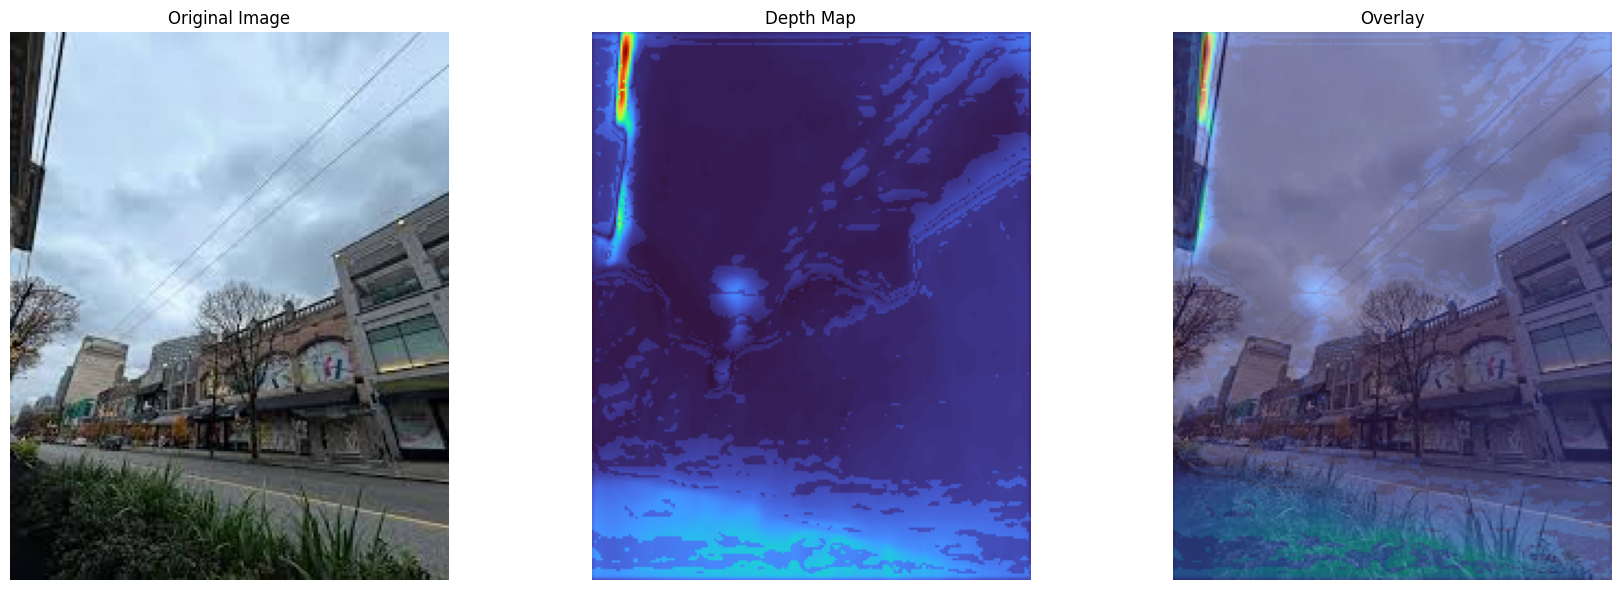

<ipython-input-7-ee32b59dbaa4>:344: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


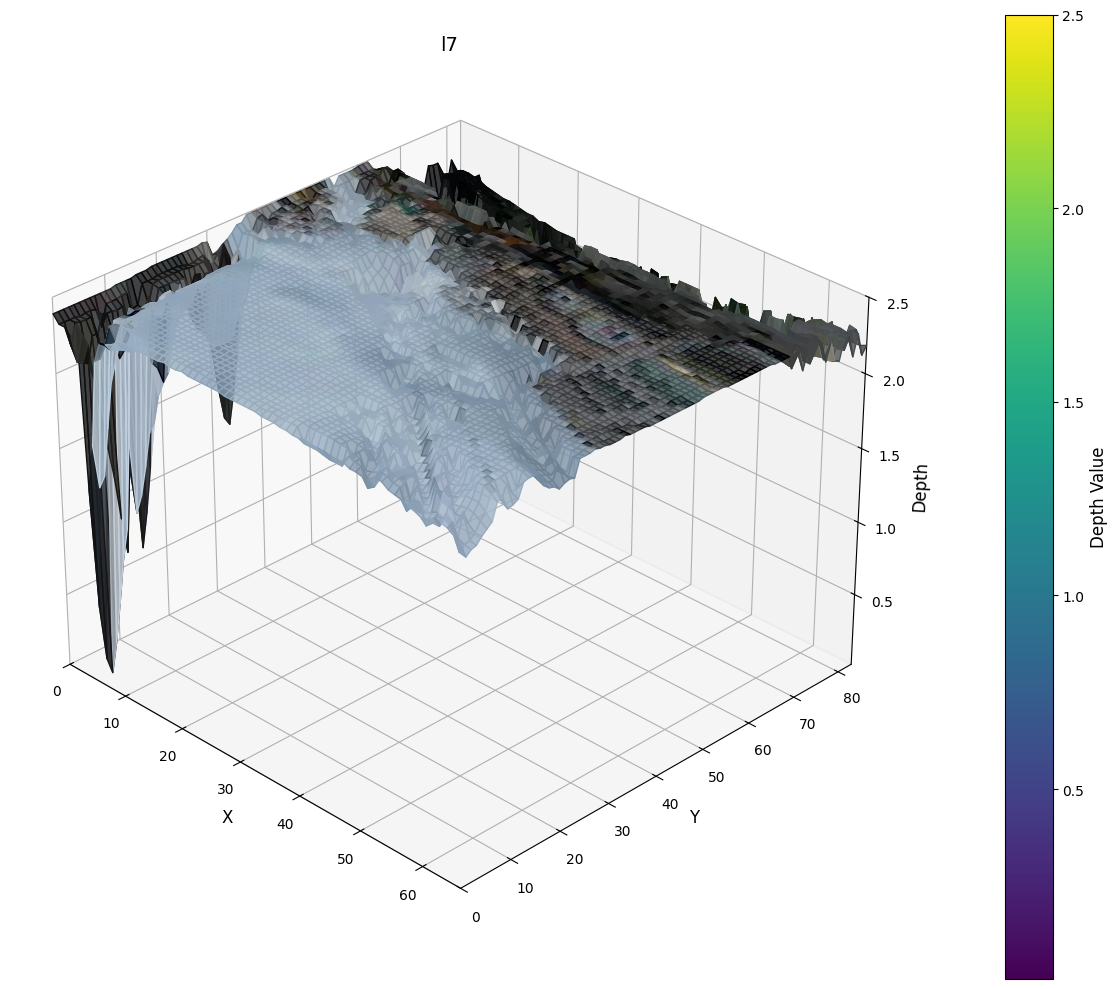

Generated 3D visualization HTML file: 3d_viz_0.html
Download this file and open it in your browser to view the 3D visualization.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Map created successfully. Choose one of these options to view it:
1. Download the HTML file and open it locally:


2. View a simplified version in Colab:


3. Direct download:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Added visualization 'l7' at location [10.0, 10.0] to the map.


KeyboardInterrupt: Interrupted by user

In [7]:
import os
import io
import cv2
import base64
import numpy as np
import urllib.request
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display, HTML, IFrame, Javascript
from google.colab import files

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
try:
    import timm
    print("timm already installed")
except ImportError:
    !pip install timm
    import timm

try:
    import folium
    print("folium already installed")
except ImportError:
    !pip install folium
    import folium

# Global variable to store the depth map collection
depth_collection = []

# Download MiDaS model (if not already downloaded)
def download_model():
    print("Downloading MiDaS model weights...")
    os.makedirs("models", exist_ok=True)

    # Small model variant
    midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
    model_path = "models/midas_v21_small_256.pt"

    if not os.path.exists(model_path):
        urllib.request.urlretrieve(midas_model_url, model_path)
        print(f"Model downloaded to {model_path}")
    else:
        print(f"Model already exists at {model_path}")

    return model_path
# Load MiDaS model
class MidasNet(torch.nn.Module):
    """MiDaS network architecture for depth estimation"""
    def __init__(self, path=None, use_large_model=True):
        super(MidasNet, self).__init__()
        if use_large_model:
            try:
                self.model = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
                print("Using DPT_Large model for better building depth estimation")
            except:
                try:
                    self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS")
                    print("Using MiDaS large model for better building depth estimation")
                except:
                    self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
                    print("Falling back to MiDaS_small model")
        else:
            self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
            print("Using MiDaS_small model")

        if path and os.path.exists(path):
            try:
                self.model.load_state_dict(torch.load(path, map_location=device))
                print(f"Loaded model weights from {path}")
            except Exception as e:
                print(f"Could not load weights from {path}, using pre-trained weights. Error: {e}")

        self.model.to(device)
        self.model.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

# Image preprocessing transformation
def transform_image(img, model_type="large"):
    """Transform image for input to MiDaS"""
    if model_type == "large":
        transform = transforms.Compose([
            transforms.Resize(384),
            transforms.CenterCrop((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
    img = transform(img).unsqueeze(0).to(device)
    return img

# Estimate depth from image
def estimate_depth(img_path, model, model_type="large"):
    """Estimate depth from an image file"""
    # Load image
    if isinstance(img_path, str):
        img = Image.open(img_path).convert("RGB")
    else:
        img = Image.fromarray(img_path).convert("RGB")

    # Original image dimensions for later resizing
    width, height = img.size

    # Transform image for model input
    transformed_img = transform_image(img, model_type)

    # Predict depth
    with torch.no_grad():
        prediction = model(transformed_img)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()

    # Apply disparity adjustment for buildings to enhance 3D effect
    depth_map = enhance_building_depth(depth_map)

    # Normalize to 0-255 range for visualization
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255.0
    depth_map = depth_map.astype(np.uint8)

    return depth_map, np.array(img)

# NEW: Function to enhance building depth by detecting vertical structures
def enhance_building_depth(depth_map, enhancement_factor=1.5):
    """Enhance building depth by detecting vertical structures"""
    # Create a copy to avoid modifying the original
    enhanced_depth = depth_map.copy()

    # Apply edge detection to find vertical structures (potential buildings)
    if len(depth_map.shape) > 2:
        # If depth_map has more than 2 dimensions, convert to 2D
        depth_map_2d = depth_map.mean(axis=2)
    else:
        depth_map_2d = depth_map

    # Compute gradients
    grad_y, grad_x = np.gradient(depth_map_2d)

    # Enhance depths where vertical gradients are large
    # (likely to be buildings or vertical structures)
    grad_magnitude = np.abs(grad_y)
    threshold = np.percentile(grad_magnitude, 70)  # Adjust percentile as needed

    # Create a mask for vertical structures
    vertical_mask = grad_magnitude > threshold

    # Apply enhancement to vertical structures
    enhanced_depth[vertical_mask] *= enhancement_factor

    return enhanced_depth

# Visualization function
def visualize_depth(rgb_img, depth_map, colormap=cv2.COLORMAP_TURBO, alpha=0.5):
    """Visualize depth map"""
    # Apply colormap to depth
    depth_colored = cv2.applyColorMap(depth_map, colormap)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    # Resize RGB image if sizes don't match
    if rgb_img.shape[:2] != depth_colored.shape[:2]:
        rgb_img = cv2.resize(rgb_img, (depth_colored.shape[1], depth_colored.shape[0]))

    # Create overlay
    overlay = cv2.addWeighted(rgb_img, 1-alpha, depth_colored, alpha, 0)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_colored)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return depth_colored, overlay

# Function to process image from URL
def process_from_url(url, model, colormap=cv2.COLORMAP_TURBO):
    """Process image from URL"""
    # Download image
    print(f"Downloading image from {url}")
    urllib.request.urlretrieve(url, "temp_image.jpg")

    # Estimate depth
    depth_map, rgb_img = estimate_depth("temp_image.jpg", model)

    # Visualize
    depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    # Clean up
    if os.path.exists("temp_image.jpg"):
        os.remove("temp_image.jpg")

    return rgb_img, depth_map, depth_colored, overlay

# Function to process uploaded image
def process_uploaded_image(model, colormap=cv2.COLORMAP_TURBO):
    """Process uploaded image"""
    print("Please upload an image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        depth_map, rgb_img = estimate_depth(filename, model)
        depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    return rgb_img, depth_map, depth_colored, overlay

# Function to process image from webcam
def process_from_webcam(model, colormap=cv2.COLORMAP_TURBO):
    """Capture and process image from webcam"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])

    # Convert binary to numpy array
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Estimate depth
    depth_map, _ = estimate_depth(img, model)

    # Visualize
    depth_colored, overlay = visualize_depth(img, depth_map, colormap)

    return img, depth_map, depth_colored, overlay

# Improved 3D visualization from depth map
def visualize_3d(rgb_img, depth_map, title="3D Visualization of Depth", downsample=3, save_fig=False, z_scale=2.5):
    """Create improved 3D visualization from depth map with enhanced building depth"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create surface plot
    z = depth_downsampled / 255.0  # Normalize to 0-1
    # Flip z to make closer objects higher
    z = 1 - z

    # Scale z to enhance building heights
    z = z * z_scale

    # Flatten for scatter
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3) / 255.0

    # Add a mesh grid
    ax.plot_surface(x, y, z, facecolors=rgb_downsampled/255.0,
                    rstride=1, cstride=1, alpha=0.8, antialiased=True)

    # Set labels and view angle
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Depth', fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set camera angle
    ax.view_init(elev=30, azim=-45)

    # Add colorbar to show depth
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(z.min(), z.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label('Depth Value', fontsize=12)

    # Add a grid
    ax.grid(True)

    # Set axis limits
    ax.set_xlim(0, x.max())
    ax.set_ylim(0, y.max())
    ax.set_zlim(z.min(), z.max())

    plt.tight_layout()

    if save_fig:
        plt.savefig('3d_visualization.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Save the data for map integration
    return {
        'x': x_flat.tolist(),
        'y': y_flat.tolist(),
        'z': z_flat.tolist(),
        'colors': colors.tolist(),
        'title': title
    }

# Function to create a 3D point cloud that can be exported
def create_point_cloud(depth_map, rgb_img, downsample=3, z_scale=3.0):
    """Create a point cloud from depth map and RGB image with enhanced building heights"""
    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Normalize depth
    z = depth_downsampled / 255.0  # Normalize to 0-1
    z = 1 - z  # Flip so closer objects are higher

    # Scale z to enhance buildings
    z = z * z_scale

    # Flatten for point cloud
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3).tolist()

    # Create point cloud data
    points = []
    for i in range(len(x_flat)):
        points.append({
            'x': float(x_flat[i]),
            'y': float(y_flat[i]),
            'z': float(z_flat[i]),
            'r': colors[i][0],
            'g': colors[i][1],
            'b': colors[i][2]
        })

    return points

# Function to update the map with 3D visualizations
def update_map_with_3d(depth_collection, map_center=[0, 0], zoom_start=2):
    """Create or update a map with 3D visualizations from the depth collection"""
    import folium

    # Create a map
    m = folium.Map(location=map_center, zoom_start=zoom_start, control_scale=True)

    # Add each 3D visualization to the map
    for i, item in enumerate(depth_collection):
        if 'geo_location' in item:
            # Create base64 thumbnail for popup
            thumbnail_html = f'<img src="data:image/jpeg;base64,{item["thumbnail"]}" style="width:100%">'

            # Create popup with button to open 3D viz
            popup_html = f"""
            <div style="width:300px">
                <h3>{item['title']}</h3>
                {thumbnail_html}
                <p>Depth visualization #{i+1}</p>
                <p>To view the 3D model, please download and open the HTML file</p>
            </div>
            """

            folium.Marker(
                location=item['geo_location'],
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=item['title'],
                icon=folium.Icon(icon='camera', prefix='fa')
            ).add_to(m)

    # Save the map to an HTML file
    map_filename = 'depth_map.html'
    m.save(map_filename)

    # Create a simple alternative map using direct HTML
    create_simple_map(depth_collection, map_center, zoom_start)

    # Display download link instead of embedding
    print(f"Map created successfully. Choose one of these options to view it:")
    print("1. Download the HTML file and open it locally:")
    display(HTML(f'<a href="./files/{map_filename}" download="{map_filename}">Download Folium Map</a>'))
    print("2. View a simplified version in Colab:")
    display(IFrame('simple_map.html', width='100%', height=500))

    # Also offer direct download via Colab
    print("3. Direct download:")
    files.download(map_filename)

    return m

# Function to create a simple map using direct HTML
def create_simple_map(depth_collection, map_center=[0, 0], zoom_start=2):
    """Create a simple map using HTML and JavaScript"""

    # Extract location data
    locations = []
    for i, item in enumerate(depth_collection):
        if 'geo_location' in item:
            locations.append({
                'lat': item['geo_location'][0],
                'lng': item['geo_location'][1],
                'title': item['title'],
                'index': i
            })

    # Create the HTML content
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Depth Map Visualization</title>
        <meta charset="utf-8">
        <style>
            body { margin: 0; padding: 0; }
            #map { height: 500px; width: 100%; }
        </style>
        <link rel="stylesheet" href="https://unpkg.com/leaflet@1.7.1/dist/leaflet.css" />
        <script src="https://unpkg.com/leaflet@1.7.1/dist/leaflet.js"></script>
    </head>
    <body>
        <div id="map"></div>
        <script>
            const map = L.map('map').setView([""" + str(map_center[0]) + """, """ + str(map_center[1]) + """], """ + str(zoom_start) + """);

            L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
                attribution: '&copy; OpenStreetMap contributors'
            }).addTo(map);

            const locations = """ + json.dumps(locations) + """;

            locations.forEach((loc) => {
                L.marker([loc.lat, loc.lng])
                    .addTo(map)
                    .bindPopup(`<b>${loc.title}</b><br>Depth visualization #${loc.index+1}`);
            });
        </script>
    </body>
    </html>
    """

    # Write to file
    filename = 'simple_map.html'
    with open(filename, 'w') as f:
        f.write(html_content)

    return filename

# Function to add a new 3D visualization to the collection with geo-location
def add_to_map(rgb_img, depth_map, depth_colored, title, location, downsample=3, z_scale=3.0):
    """Add a 3D visualization to the map collection with enhanced building height"""
    global depth_collection

    # Create point cloud data with scaled z values for better building visualization
    point_cloud = create_point_cloud(depth_map, rgb_img, downsample, z_scale)

    # Create a thumbnail for the popup
    plt.figure(figsize=(4, 3))
    plt.imshow(depth_colored)
    plt.axis('off')
    plt.tight_layout(pad=0)

    # Save thumbnail as base64
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', bbox_inches='tight', pad_inches=0)
    plt.close()
    buf.seek(0)
    thumbnail = base64.b64encode(buf.read()).decode('utf-8')

    # Create the entry for the collection
    entry = {
        'title': title,
        'geo_location': location,
        'thumbnail': thumbnail,
        'point_cloud': point_cloud,
        'original_shape': depth_map.shape
    }

    # Add to collection
    depth_collection.append(entry)

    # Generate individual 3D HTML for this entry
    generate_3d_html(len(depth_collection) - 1)

    # Update the map
    update_map_with_3d(depth_collection)

    print(f"Added visualization '{title}' at location {location} to the map.")
    return len(depth_collection) - 1  # Return index of the added entry

# IMPROVED: Function to generate an HTML file with a 3D visualization using Three.js
# IMPROVED: Function to generate an HTML file with a 3D visualization using Three.js
def generate_3d_html(index):
    """Generate an HTML file with a 3D visualization of a point cloud using Three.js"""
    if index >= len(depth_collection):
        print(f"Error: Index {index} out of range")
        return

    item = depth_collection[index]
    point_cloud = item['point_cloud']

    # Create a simplified point cloud for the web
    # Sample points to reduce size if needed
    max_points = 15000  # Increased from 10000 for more detail
    if len(point_cloud) > max_points:
        step = len(point_cloud) // max_points
        point_cloud = point_cloud[::step]

    # Convert point cloud to a format for Three.js
    points_data = []
    colors_data = []
    for point in point_cloud:
        points_data.append([point['x'], point['y'], point['z']])
        colors_data.append([point['r']/255, point['g']/255, point['b']/255])

    # Create HTML content - using unpkg.com as CDN for better compatibility
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>{item['title']} - 3D Visualization</title>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <script src="https://unpkg.com/three@0.128.0/build/three.min.js"></script>
        <script src="https://unpkg.com/three@0.128.0/examples/js/controls/OrbitControls.js"></script>
        <script src="https://unpkg.com/dat.gui@0.7.7/build/dat.gui.min.js"></script>
        <style>
            body {{ margin: 0; overflow: hidden; }}
            canvas {{ width: 100%; height: 100%; display: block; }}
            #info {{
                position: absolute;
                top: 10px;
                width: 100%;
                text-align: center;
                color: white;
                font-family: Arial, sans-serif;
                font-size: 14px;
                z-index: 100;
                pointer-events: none;
            }}
            #controls {{
                position: absolute;
                bottom: 10px;
                left: 10px;
                color: white;
                font-family: Arial, sans-serif;
                font-size: 12px;
                z-index: 100;
                background-color: rgba(0,0,0,0.5);
                padding: 10px;
                border-radius: 5px;
            }}
        </style>
    </head>
    <body>
        <div id="info">{item['title']} - 3D Building Visualization</div>
        <div id="controls">
            Rotate: Left Mouse | Pan: Right Mouse | Zoom: Scroll<br>
            Building Mode: <span id="buildingMode">On</span>
        </div>
        <script>
            // Scene setup
            const scene = new THREE.Scene();
            scene.background = new THREE.Color(0x111111);

            // Camera setup
            const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
            camera.position.set(0, -50, 50);
            camera.up.set(0, 0, 1); // Set z-up

            // Renderer setup
            const renderer = new THREE.WebGLRenderer({{ antialias: true }});
            renderer.setSize(window.innerWidth, window.innerHeight);
            document.body.appendChild(renderer.domElement);

            // Controls
            const controls = new THREE.OrbitControls(camera, renderer.domElement);
            controls.enableDamping = true;
            controls.dampingFactor = 0.25;

            // Light
            const ambientLight = new THREE.AmbientLight(0xffffff, 0.5);
            scene.add(ambientLight);

            const directionalLight = new THREE.DirectionalLight(0xffffff, 0.8);
            directionalLight.position.set(1, 1, 1);
            scene.add(directionalLight);

            // Helper functions
            function normalizePoints(points) {{
                // Find bounds
                let minX = Infinity, minY = Infinity, minZ = Infinity;
                let maxX = -Infinity, maxY = -Infinity, maxZ = -Infinity;

                points.forEach(p => {{
                    minX = Math.min(minX, p[0]);
                    minY = Math.min(minY, p[1]);
                    minZ = Math.min(minZ, p[2]);
                    maxX = Math.max(maxX, p[0]);
                    maxY = Math.max(maxY, p[1]);
                    maxZ = Math.max(maxZ, p[2]);
                }});

                // Center and scale
                const centerX = (minX + maxX) / 2;
                const centerY = (minY + maxY) / 2;
                const centerZ = (minZ + maxZ) / 2;

                const scale = 100 / Math.max(maxX - minX, maxY - minY, maxZ - minZ);

                return points.map(p => [
                    (p[0] - centerX) * scale,
                    (p[1] - centerY) * scale,
                    (p[2] - centerZ) * scale
                ]);
            }}

            // Point cloud data
            const pointsData = {json.dumps(points_data)};
            const colorsData = {json.dumps(colors_data)};

            // Normalize point positions for better display
            const normalizedPoints = normalizePoints(pointsData);

            // Create point cloud
            const geometry = new THREE.BufferGeometry();
            const positions = [];
            const colors = [];

            for (let i = 0; i < normalizedPoints.length; i++) {{
                positions.push(normalizedPoints[i][0], normalizedPoints[i][1], normalizedPoints[i][2]);
                colors.push(colorsData[i][0], colorsData[i][1], colorsData[i][2]);
            }}

            geometry.setAttribute('position', new THREE.Float32BufferAttribute(positions, 3));
            geometry.setAttribute('color', new THREE.Float32BufferAttribute(colors, 3));

            // Create THREE.Points for point cloud visualization
            const pointMaterial = new THREE.PointsMaterial({{
                size: 0.8,  // larger point size
                vertexColors: true,
                sizeAttenuation: true
            }});

            const pointCloud = new THREE.Points(geometry, pointMaterial);
            scene.add(pointCloud);

            // Add building mesh visualization
            // This will create a mesh from the point cloud to better show building structure
            function createBuildingMesh() {{
                // Clone the normalized points for the mesh
                const meshGeometry = new THREE.BufferGeometry();
                meshGeometry.setAttribute('position', geometry.getAttribute('position'));
                meshGeometry.setAttribute('color', geometry.getAttribute('color'));

                // Compute vertex normals for better lighting
                meshGeometry.computeVertexNormals();

                // Create mesh material with vertex colors
                const meshMaterial = new THREE.MeshPhongMaterial({{
                    vertexColors: true,
                    flatShading: true,
                    shininess: 10,
                    transparent: true,
                    opacity: 0.7
                }});

                // Create the mesh
                return new THREE.Mesh(meshGeometry, meshMaterial);
            }}

            // Add the mesh (initially hidden)
            const buildingMesh = createBuildingMesh();
            scene.add(buildingMesh);
            buildingMesh.visible = false;

            // Add axes helper
            const axesHelper = new THREE.AxesHelper(20);
            scene.add(axesHelper);

            // Add grid
            const gridHelper = new THREE.GridHelper(100, 10);
            gridHelper.rotation.x = Math.PI / 2;
            scene.add(gridHelper);

            // GUI controls
            const gui = new dat.GUI();
            const params = {{
                pointSize: 0.8,
                showAxes: true,
                showGrid: true,
                rotateModel: false,
                buildingMode: true,
                buildingExaggeration: 1.0
            }};

            gui.add(params, 'pointSize', 0.1, 3).onChange(value => {{
                pointMaterial.size = value;
            }});

            gui.add(params, 'showAxes').onChange(value => {{
                axesHelper.visible = value;
            }});

            gui.add(params, 'showGrid').onChange(value => {{
                gridHelper.visible = value;
            }});

            gui.add(params, 'rotateModel');

            // Building mode toggle
            gui.add(params, 'buildingMode').onChange(value => {{
                buildingMesh.visible = value;
                pointCloud.visible = !value;
                document.getElementById('buildingMode').textContent = value ? 'On' : 'Off';
            }});

            gui.add(params, 'buildingExaggeration', 0.5, 3.0).onChange(value => {{
                // Scale the z-coordinates
                const positions = geometry.getAttribute('position').array;
                for (let i = 0; i < positions.length; i += 3) {{
                    positions[i + 2] = normalizedPoints[i/3][2] * value;
                }}
                geometry.getAttribute('position').needsUpdate = true;

                // Update the building mesh too
                const meshPositions = buildingMesh.geometry.getAttribute('position').array;
                for (let i = 0; i < meshPositions.length; i += 3) {{
                    meshPositions[i + 2] = normalizedPoints[i/3][2] * value;
                }}
                buildingMesh.geometry.getAttribute('position').needsUpdate = true;
            }});

            // Animation loop
            function animate() {{
                requestAnimationFrame(animate);

                controls.update();

                if (params.rotateModel) {{
                    pointCloud.rotation.z += 0.005;
                    buildingMesh.rotation.z += 0.005;
                }}

                renderer.render(scene, camera);
            }}

            // Handle window resize
            window.addEventListener('resize', () => {{
                camera.aspect = window.innerWidth / window.innerHeight;
                camera.updateProjectionMatrix();
                renderer.setSize(window.innerWidth, window.innerHeight);
            }}, false);

            // Start animation
            animate();
        </script>
    </body>
    </html>
    """

    # Write to file
    filename = f'3d_viz_{index}.html'
    with open(filename, 'w') as f:
        f.write(html_content)

    print(f"Generated 3D visualization HTML file: {filename}")
    print("Download this file and open it in your browser to view the 3D visualization.")

    # Offer download via Colab
    files.download(filename)

    return filename

# Main function
def main():
    """Main execution function"""
    print("3D Building Depth Estimation Tool")
    print("=================================")
    print("This tool can estimate depth maps from images and create 3D visualizations")
    print("especially optimized for buildings and urban structures.")
    print("\nOptions:")
    print("1. Process image from URL")
    print("2. Upload and process image")
    print("3. Capture and process image from webcam")
    print("4. Update map with all visualizations")
    print("5. Exit")

    # Download model
    model_path = download_model()

    # Load model
    model = MidasNet(path=model_path, use_large_model=True)

    while True:
        choice = input("\nEnter your choice (1-5): ")

        if choice == '1':
            url = input("Enter image URL: ")
            title = input("Enter a title for this visualization: ")

            # Get geo-location
            print("Enter approximate geo-location (latitude, longitude):")
            lat = float(input("Latitude: "))
            lon = float(input("Longitude: "))

            # Process image
            rgb_img, depth_map, depth_colored, overlay = process_from_url(url, model)

            # Visualize in 3D
            visualize_3d(rgb_img, depth_map, title=title)

            # Add to map
            add_to_map(rgb_img, depth_map, depth_colored, title, [lat, lon])

        elif choice == '2':
            title = input("Enter a title for this visualization: ")

            # Get geo-location
            print("Enter approximate geo-location (latitude, longitude):")
            lat = float(input("Latitude: "))
            lon = float(input("Longitude: "))

            # Process uploaded image
            rgb_img, depth_map, depth_colored, overlay = process_uploaded_image(model)

            # Visualize in 3D
            visualize_3d(rgb_img, depth_map, title=title)

            # Add to map
            add_to_map(rgb_img, depth_map, depth_colored, title, [lat, lon])

        elif choice == '3':
            title = input("Enter a title for this visualization: ")

            # Get geo-location
            print("Enter approximate geo-location (latitude, longitude):")
            lat = float(input("Latitude: "))
            lon = float(input("Longitude: "))

            # Process webcam image
            rgb_img, depth_map, depth_colored, overlay = process_from_webcam(model)

            # Visualize in 3D
            visualize_3d(rgb_img, depth_map, title=title)

            # Add to map
            add_to_map(rgb_img, depth_map, depth_colored, title, [lat, lon])

        elif choice == '4':
            # Update map with all visualizations
            if len(depth_collection) > 0:
                # Calculate center of all points
                lats = [item['geo_location'][0] for item in depth_collection if 'geo_location' in item]
                lons = [item['geo_location'][1] for item in depth_collection if 'geo_location' in item]

                if lats and lons:
                    center = [sum(lats)/len(lats), sum(lons)/len(lons)]
                    update_map_with_3d(depth_collection, map_center=center)
                else:
                    update_map_with_3d(depth_collection)
            else:
                print("No visualizations to show on map yet.")

        elif choice == '5':
            print("Exiting. Thank you for using the 3D Building Depth Estimation Tool!")
            break

        else:
            print("Invalid choice. Please enter a number between 1 and 5.")

# Run the main function
if __name__ == "__main__":
    main()